# DeepInsight SqueezeNet Example

This example shows a case of using the output of
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch. This follows the general approach used in the
original DeepInsight paper.

In [ ]:
# !pip install torch

## DeepInsight

In [3]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# Display the current device
print(f"Current device: {device}")


GPU is not available. Using CPU.
Current device: cpu


In [4]:
!python3 -m pip -q install git+https://github.com/alok-ai-lab/pyDeepInsight.git


In [5]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load example csv data and split into training and testing sets

View path

In [6]:
!pwd

/Users/allan/Desktop/flower


In [7]:
!ls /Users/allan/dataset/

COVID-19_Radiography_Dataset cancer.csv
COVID19-BIG                  cancer_synthetic.csv
COVID19-BIG.zip              cancer_test.csv
Covid19-dataset              cancer_test_headers.csv
Covid19-test                 higgs.zip
HIGGS.csv                    stroke.csv
HIGGS.csv.gz                 stroke_2024.csv
HIGGS_test.csv               stroke_balanced.csv
Iris.csv                     stroke_balancedH.csv
Iris_headers.csv             stroke_test.csv
Iris_test.csv


In [8]:
# Load your CSV data
# data = pd.read_csv('/gpfs/home4/aduah/flower/dataset/cancer_test_headers.csv')
data = pd.read_csv('/Users/allan/dataset/cancer_synthetic.csv')


# Assuming the first column is the target, separate features and target
X = data.iloc[:, 1:].values #take values
y = data.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7854)

In [9]:
# # Load your CSV data
# data = pd.read_csv('/gpfs/home4/aduah/flower/dataset/stroke_balancedH.csv')
# # data = pd.read_csv('/Users/allan/dataset/stroke_balancedH.csv')


# # Assuming the first column is the target, separate features and target
# X = data.iloc[7500:, 1:].values #take values
# y = data.iloc[7500:, 0].values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)

In [10]:
np.unique(y, return_counts=True)

(array([0, 1]), array([357, 357]))

Normalize data using LogScaler and encode classes

In [13]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [14]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size #IMPORTANT VAR!!----

### CHANGE PERPLEXITY

Create t-SNE object

In [15]:
#CHANGE perplexity THIS!!!!!!!!!
perplexity=29 #should be less than n_features
random_state =42

In [16]:
from sklearn.decomposition import PCA

distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random', 
    learning_rate='auto',
    n_jobs=-1,
    perplexity=perplexity, # should be less than n_features
    random_state = random_state
)
reducer =  PCA(n_components=2,     
              random_state = random_state
)

Initialize image transformer.

In [17]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

Train image transformer on training data and transform training
and testing sets. Values should be between 0 and 1.

In [18]:
print(reducer)
print(X_train_norm)

PCA(n_components=2, random_state=42)
[[0.3773612  0.40082944 0.5982725  ... 0.00877297 0.04357537 0.01465109]
 [0.37901264 0.38877594 0.60072362 ... 0.01259355 0.04641992 0.01338684]
 [0.39603106 0.42085816 0.62105626 ... 0.01721626 0.04131713 0.0151954 ]
 ...
 [0.367676   0.42490379 0.58884863 ... 0.01388562 0.04566671 0.0168256 ]
 [0.40296438 0.42746698 0.62842904 ... 0.01924487 0.04750802 0.01678307]
 [0.40394894 0.43112443 0.6295572  ... 0.0177345  0.0452294  0.01506171]]


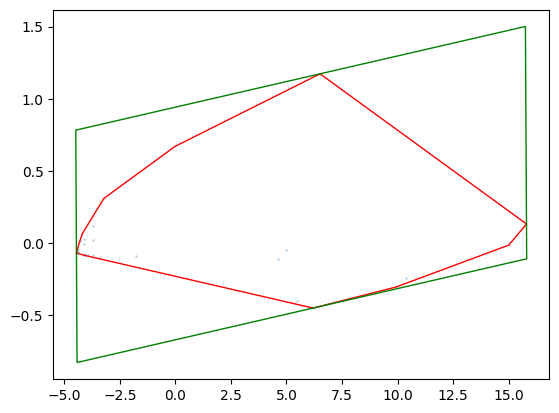

In [19]:
%matplotlib inline
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

In [20]:
# !pip install seaborn

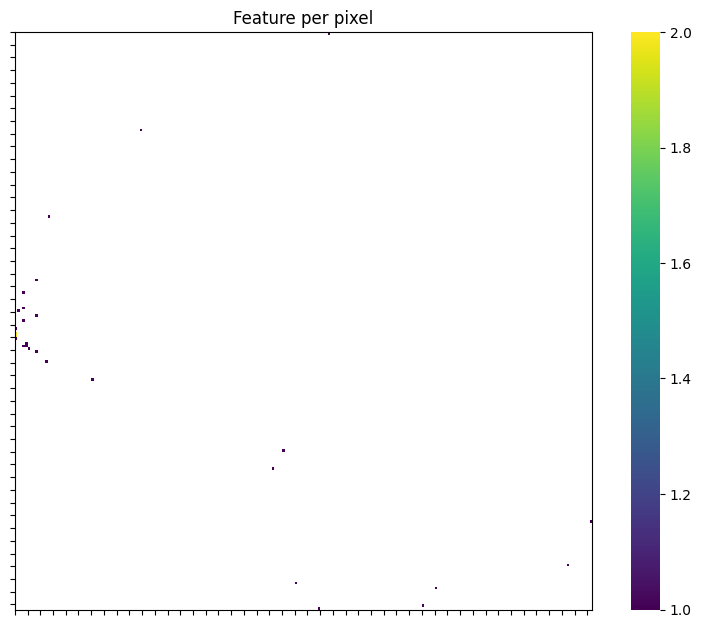

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.,
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Feature per pixel")

The following are showing plots for the image matrices first four samples
of the training set.

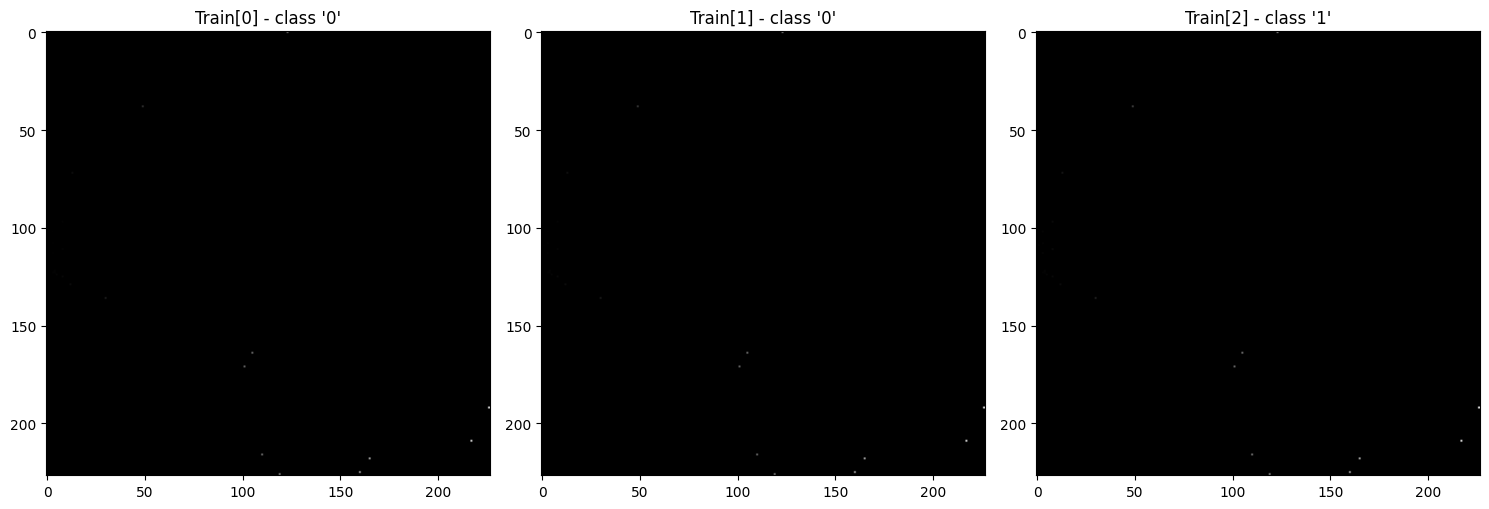

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the
training data.

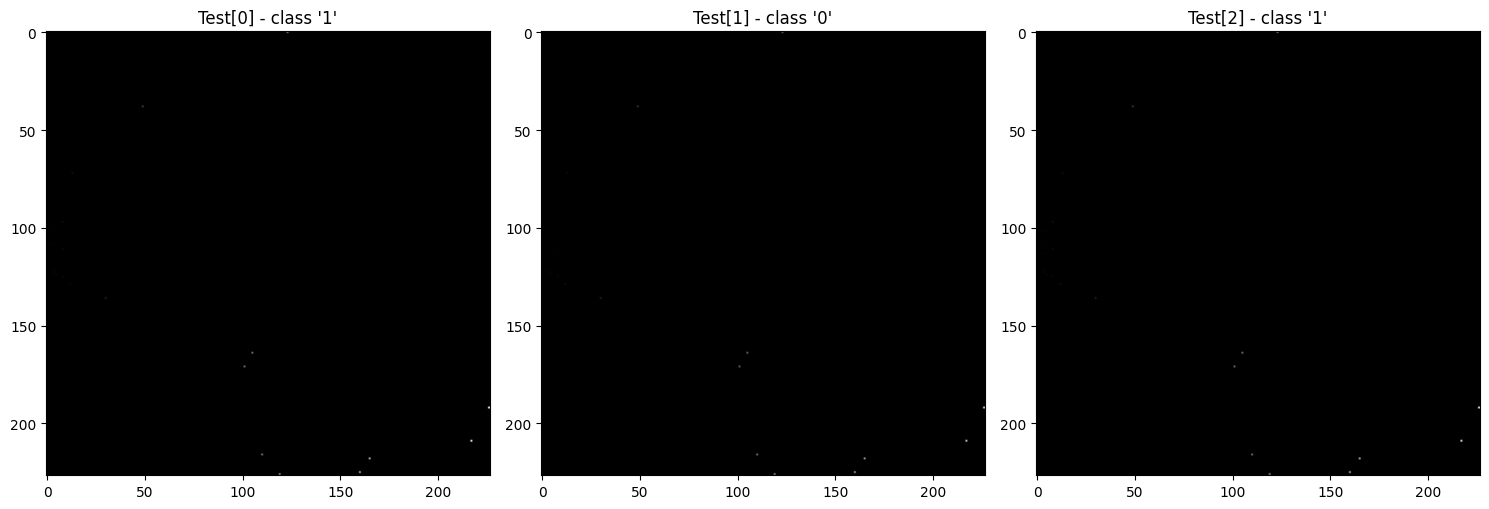

In [23]:
# X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

## SqueezeNet

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings;
warnings.simplefilter('ignore')

In [25]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

Modify [PyTrorch SqueezeNet 1.1][1] output to number of classes

[1]: https://pytorch.org/vision/stable/models/squeezenet.html

In [26]:
# model = torchvision.models.squeezenet1_1(weights='DEFAULT')
# model.classifier.append(nn.Flatten())
# _ = model.classifier.append(nn.Linear(1000, num_classes))

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not
required.


In [27]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [28]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(le.transform(y_test))

In [29]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Generate pyTorch datasets and dataloaders for training and testing sets.

# flower

In [30]:
!pip install -q flwr[simulation]

zsh:1: no matches found: flwr[simulation]


In [31]:
NUM_CLIENTS =20
NUM_ROUNDS= 50
EPOCHS = 10
DATASET1 = 'Cancer dataset'
DATASET2 = 'Stroke dataset'

In [32]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.model = torchvision.models.squeezenet1_1(weights='DEFAULT')
        self.model.classifier.append(nn.Flatten())
        self.model.classifier.append(nn.Linear(1000, num_classes))

    def forward(self, x):
        return self.model(x)

In [33]:
def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """Download dataset and generate IID partitions."""

    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    testset = TensorDataset(X_test_tensor, y_test_tensor)


    # split trainset into `num_partitions` trainsets (one per client)
    # figure out number of training examples per partition
    num_images = len(trainset) // num_partitions
    remainder = len(trainset) % num_partitions

    # a list of partition lenghts (all partitions are of equal size)
    partition_len = [num_images] * num_partitions
    for i in range(remainder):
        partition_len[i] += 1

    # split randomly. This returns a list of trainsets, each with `num_images` training examples
    # Note this is the simplest way of splitting this dataset.
    trainsets = random_split(
        trainset, partition_len, torch.Generator().manual_seed(42)
    )

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    # for each train set, let's put aside some training examples for validation
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, [num_train, num_val], torch.Generator().manual_seed(42)
        )

        # construct data loaders and append to their respective list.
        # In this way, the i-th client will get the i-th element in the trainloaders list and the i-th element in the valloaders list
        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2)
        )

    # We leave the test set intact (i.e. we don't partition it)
    # This test set will be left on the server side and we'll be used to evaluate the
    # performance of the global model after each round.
    # Please note that a more realistic setting would instead use a validation set on the server for
    # this purpose and only use the testset after the final round.

    testloader = DataLoader(testset, batch_size=batch_size)

    return trainloaders, valloaders, testloader

In [34]:
batch_size = 200

trainloaders, valloaders, testloader = prepare_dataset(NUM_CLIENTS, batch_size)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [36]:
import time

def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        # running_loss = 0.0
        for images, labels in trainloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        #     running_loss += loss.item()
        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")
    return net

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    #correct, total, loss = 0, 0, 0.0
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # accuracy = correct / total
    accuracy = correct / len(testloader.dataset)
    # avg_loss = loss / len(testloader)
    # print(f"Accuracy on test set: {100 * accuracy:.2f}%")
    # print(f"Avg Loss on test set: {avg_loss:.4f}")
    return loss, accuracy

def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""

    start_time = time.time()

    # uses gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Instantiate the SqueezeNet model
    model = Net(num_classes=num_classes)
    model.to(device)



    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    # momentum=0.8,
    weight_decay=1e-05
)

    # Create datasets and data loaders
    batch_size = 200

    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Train the model
    trained_model = train(model, trainloader, optimizer, epochs)

    # Test the model
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

    # End the timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.2f} seconds")


# # Run the centralised training and testing
# run_centralised(epochs=100, lr=0.01)


In [37]:
import flwr as fl
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes)

        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        #optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        optimizer = optim.AdamW(self.model.parameters(),lr=1e-04, weight_decay=1e-05)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optimizer, epochs=EPOCHS)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(
            self.model, self.valloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [38]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole test set)."""

        model = Net(num_classes)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn



In [39]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

In [40]:
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping
from flwr.server.strategy import DifferentialPrivacyServerSideFixedClipping

from flwr.server.strategy import DifferentialPrivacyClientSideAdaptiveClipping
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping

from flwr.client.mod import fixedclipping_mod, adaptiveclipping_mod

# now we can define the strategy
strategy = fl.server.strategy.FedAvg(
    #fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    #fraction_evaluate=0.1,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader),
    # initial_parameters=parameters
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

# dp_strategy = DifferentialPrivacyClientSideFixedClipping(
#         strategy,
#         noise_multiplier=1,
#         clipping_norm=10,
#         num_sampled_clients=NUM_CLIENTS,
#     )

dp_strategy = DifferentialPrivacyServerSideAdaptiveClipping(
        strategy,
        noise_multiplier=0.01,
        num_sampled_clients=NUM_CLIENTS,
    )

# #Add fixedclipping_mod to the client-side mods
# app = fl.client.ClientApp(
#         client_fn=client_fn_callback,
#         mods=[
#             fixedclipping_mod,
#         ]
# )
client_resources = {"num_cpus": 3, "num_gpus": 0.05}

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),  # let's run for 10 rounds
    strategy=dp_strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources
)


INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-06-19 16:43:48,600	INFO worker.py:1621 -- Started a local Ray instance.


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid(True)
plt.ylabel("Accuracy DeepInsight (%)")
plt.xlabel("Round")
plt.title(f"{DATASET1} Accuracy Over {NUM_ROUNDS} Rounds {NUM_CLIENTS} clients")
# Specify the directory where you want to save the plot
save_directory = "/gpfs/home4/aduah/flower/metrics"
 
# Ensure the directory exists, create it if it does not
os.makedirs(save_directory, exist_ok=True)

# Construct the full path for the file CANCER
save_path = os.path.join(save_directory, f"DeepInsightPCA_{DATASET1}_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedAvgDP001")

# save_path = os.path.join(save_directory, f"DeepInsight_{DATASET2}_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedAvgDP_001")


# Save the plot to the specified directory
plt.savefig(save_path)
plt.show()

In [37]:
import csv
import os

# Define the save directory
save_directory = "/gpfs/home4/aduah/flower/metrics"

# Create the directory if it does not exist
os.makedirs(save_directory, exist_ok=True)

csv_filename = f"DeepInsightPCA_{DATASET1}_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedAvg.csv"

# Define the CSV filename
# csv_filename = f"DeepInsight_{DATASET2}_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedAvgDP_001.csv"

# Create the full path for the CSV file
csv_filepath = os.path.join(save_directory, csv_filename)

# Save the data to the CSV file
with open(csv_filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Round', 'Accuracy'])
    for r, a in zip(round, acc):
        writer.writerow([r, a])

print(f"Data saved to {csv_filepath}")


NameError: name 'acc' is not defined

-----------------------------

---



# Saving Model

In [ ]:
# saves it per round advisable to make a folder and save the rounds

In [44]:
import csv
import os
import glob

from typing import List, Union, Optional, Tuple, Dict
import flwr as fl
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes, Parameters, Scalar

net = Net(num_classes=num_classes).to(device)
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            save_dir = "saved_model_rounds"
            os.makedirs(save_dir, exist_ok=True)

            # Save the model in the specified directory
            save_path = os.path.join(save_dir, f"model_round_{server_round}.pth")
            torch.save(net.state_dict(), save_path)
            print(f"Model saved at {save_path}")


        return aggregated_parameters, aggregated_metrics
strategy = SaveModelStrategy(
    #fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    #fraction_evaluate=0.1,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader),
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset
client_resources = {"num_cpus": 3, "num_gpus": 0.05}

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources
)



INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1070556f0>>
Traceback (most recent call last):
  File "/Users/allan/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [57]:
# Loading saved model
# Takes last round in this case

In [42]:
net = Net(num_classes=num_classes).to(device)

In [ ]:
import glob
import os 
# list_of_files = [fname for fname in glob.glob("./saved_model_rounds/model_round_*")]
list_of_files = [fname for fname in glob.glob("./saved_model_CANCER_5C/model_round_*")]
latest_round_file = max(list_of_files, key=os.path.getctime)
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file) #load saved model round
net.load_state_dict(state_dict)
net.to(device) #sends model to device
state_dict_ndarrays = [v.cpu().numpy() for v in net.state_dict().values()]
parameters = fl.common.ndarrays_to_parameters(state_dict_ndarrays) # model weights for FL

In [45]:
# Predicting

In [66]:
net.to('cpu')
model = net.eval()

with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")


The train accuracy was 0.662
The test accuracy was 0.781


## Loop through saved models in directory and predict

In [43]:
import glob
import os
import torch
from sklearn.metrics import accuracy_score

net = Net(num_classes=num_classes).to(device)

# Define the directory where the saved models are located
model_directory = "./saved_model_CANCER_5C/"

# Get a list of all saved model files
list_of_files = [fname for fname in glob.glob(os.path.join(model_directory, "model_round_*"))]

# Loop through each saved model file and make predictions
for model_file in list_of_files:
    print(f"Loading pre-trained model from: {model_file}")
    
    # Load the saved model state
    state_dict = torch.load(model_file, map_location=torch.device('cpu'))  # Ensure the model is loaded on CPU
    net.load_state_dict(state_dict)
    net.to('cpu')  # Ensure the model is on CPU
    model = net.eval()
    
    # Convert state_dict to parameters for FL (if needed)
    state_dict_ndarrays = [v.cpu().numpy() for v in net.state_dict().values()]
    parameters = fl.common.ndarrays_to_parameters(state_dict_ndarrays)  # Model weights for FL
    
    # Send model to CPU and set to evaluation mode
    net.to('cpu')
    model = net.eval()
    
    # Predict on training data
    with torch.no_grad():
        y_hat_train = model(X_train_tensor)
    train_predicted = torch.max(y_hat_train, 1)[1]
    
    # Predict on test data
    with torch.no_grad():
        y_hat_test = model(X_test_tensor)
    test_predicted = torch.max(y_hat_test, 1)[1]
    
    # Calculate and print accuracy
    train_accuracy = accuracy_score(train_predicted, y_train_tensor)
    test_accuracy = accuracy_score(test_predicted, y_test_tensor)
    print(f"Model: {os.path.basename(model_file)} - Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")


Loading pre-trained model from: ./saved_model_CANCER_5C/model_round_144_pca_cancer.pth
Model: model_round_144_pca_cancer.pth - Train Accuracy: 0.890, Test Accuracy: 0.874


In [ ]:
# Run on saved parameters in FL by calling it again

In [ ]:
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping
from flwr.server.strategy import DifferentialPrivacyServerSideFixedClipping

from flwr.server.strategy import DifferentialPrivacyClientSideAdaptiveClipping
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping

from flwr.client.mod import fixedclipping_mod, adaptiveclipping_mod

# now we can define the strategy
strategy = fl.server.strategy.FedAvg(
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader),
    initial_parameters=parameters #SAVED MODEL HERE
)

client_resources = {"num_cpus": 13, "num_gpus": 0.2}

history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources
)
